# Collect and check results

This notebook collects the results of multiple runs and checks them

In [42]:
import copy
import glob
import json
import os
import pickle
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from omegaconf import DictConfig

## Collect results

In [9]:
files = []
files.extend(glob.glob('../link_prediction/2023-11-01/*/*'))

files = [name for name in files if os.path.isdir(name)]

In [17]:
logits_test = None
predictions = None
outputs_test = None

In [52]:
df = None
all_results = []
for name in files:
    try:
        with open(f'{name}/.hydra/config.yaml', 'r') as f:
            cfg = yaml.safe_load(f)
        with open(f'{name}/.hydra/overrides.yaml', 'r') as f:
            overrides = yaml.safe_load(f)
        # replace the values of the original config with the override values
        for item in overrides:
            key, value = item.split('=')
            cfg[key] = value
        cfg = DictConfig(cfg)

        parsed_cfg = {}
        for key, value in cfg.items():
            if isinstance(value, DictConfig):
                for key2, value2 in value.items():
                    parsed_cfg[f'{key}.{key2}'] = value2
        for key, value in cfg.items():
            if not isinstance(value, DictConfig):
                parsed_cfg[key] = value

        # if df is None:
        #     df = pd.DataFrame(columns=[*parsed_cfg.keys(), 'acc_mean', 'acc_std', 'loss_mean', 'loss_std', 'cca_mean', 'cca_std', 'cka_mean', 'cka_std', 'procrustess_mean', 'procrustess_std'])

        if not os.path.exists(f'{name}/cka/CKAs_test.npy'):
            continue  # skip incomplete runs

        with open(f'{name}/predictions/evals.json') as f:
            evals = json.load(f)
        with open(f'{name}/predictions/logits_test.json', 'rb') as f:
            logits_test = pickle.load(f)
        # with open(f'{name}/predictions/outputs_test.json', 'rb') as f:
        #     outputs_test = pickle.load(f)
        # with open(f'{name}/predictions/predictions.json', 'rb') as f:
        #     predictions = pickle.load(f)
        pi_distr = []
        for first, second in itertools.combinations(logits_test, 2):
            diff = np.linalg.norm(first - second)
            pi_distr.append(diff)
        pi_distr_mean = np.average(pi_distr)
        pi_distr_std = np.std(pi_distr)

        if os.path.exists(f'{name}/cka/CCAs_test.npy'):
            CCAs = np.load(f'{name}/cka/CCAs_test.npy')
        else:
            CCAs = None
        CKAs = np.load(f'{name}/cka/CKAs_test.npy')
        # rashomon_capacity = np.load(f'{name}/predictions/rashomon_capacity.npy')

        loss = [x['test_loss'] for x in evals]
        loss_mean = np.average(loss)
        loss_std = np.std(loss)
        if CCAs is not None:
            cca_mean = np.mean(CCAs, axis=0)
            cca_std = np.std(CCAs, axis=0)
        cka_mean = np.mean(CKAs, axis=0)
        cka_std = np.std(CKAs, axis=0)
        # rashomon_capacity_mean = np.average(rashomon_capacity)
        # rashomon_capacity_std = np.std(rashomon_capacity)

        if os.path.exists(f'{name}/cka/procrustess_test.npy'):
            procrustess = np.load(f'{name}/cka/procrustess_test.npy')
            procrustess_mean = np.average(procrustess, axis=0)
            procrustess_std = np.std(procrustess, axis=0)
        else:
            procrustess = None
            procrustess_mean = None
            procrustess_std = None

        if os.path.exists(f'{name}/cka/rsa_coss_test.npy'):
            rsa_cos = np.load(f'{name}/cka/rsa_coss_test.npy')
            rsa_cos_mean = np.average(rsa_cos, axis=0)
            rsa_cos_std = np.std(rsa_cos, axis=0)
        else:
            rsa_cos = None
            rsa_cos_mean = None
            rsa_cos_std = None

        results = {**parsed_cfg, 'loss': loss, 'loss_mean': loss_mean, 'loss_std': loss_std, 'pi_distr': pi_distr, 'pi_distr_mean': pi_distr_mean, 'pi_distr_std': pi_distr_std,
                   }
        if CCAs is not None:
            results.update({f'cca_{i}': CCAs[:, i, i] for i in range(CCAs.shape[1])})
        results.update({f'cka_{i}': CKAs[:, i, i] for i in range(CKAs.shape[1])})
        if procrustess is not None:
            results.update({f'procrustess_{i}': procrustess[:, i, i] for i in range(procrustess.shape[1])})
        if rsa_cos is not None:
            results.update({f'rsa_cos_{i}': rsa_cos[:, i, i] for i in range(rsa_cos.shape[1])})
        all_results.append(results)
        if CCAs is not None:
            results.update({f'cca_mean_{i}': cca_mean[i, i] for i in range(cca_mean.shape[0])})
            results.update({f'cca_std_{i}': cca_std[i, i] for i in range(cca_std.shape[0])})
        results.update({f'cka_mean_{i}': cka_mean[i, i] for i in range(cka_mean.shape[0])})
        results.update({f'cka_std_{i}': cka_std[i, i] for i in range(cka_std.shape[0])})

        if rsa_cos is not None:
            results.update({f'rsa_cos_mean_{i}': rsa_cos_mean[i, i] for i in range(rsa_cos_mean.shape[0])})
            results.update({f'rsa_cos_std_{i}': rsa_cos_std[i, i] for i in range(rsa_cos_std.shape[0])})
        if procrustess is not None:
            results.update({f'procrustess_mean_{i}': procrustess_mean[i, i] for i in range(procrustess_mean.shape[0])})
            results.update({f'procrustess_std_{i}': procrustess_std[i, i] for i in range(procrustess_std.shape[0])})
        row_df = pd.DataFrame([results])
        df = pd.concat([df, row_df], ignore_index=True)
    except:
        pass

df = pd.DataFrame(all_results).infer_objects()
for column in ['model.hidden_dim', 'model.num_layers', 'model.dropout_p', 'optim.weight_decay', 'optim.learning_rate']:
    if column in df:
        df[column] = df[column].apply(pd.to_numeric)

E:\miniconda3\envs\gnn-multistability\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [53]:
df

,optim.name,optim.learning_rate,optim.weight_decay,cka.use_masks,cka.mode,cka.save_to_disk,seed,datasplit_seed,keep_init_seed_constant,keep_train_seed_constant,...,cka_mean_3,cka_std_3,procrustess_mean_3,procrustess_std_3,cka_4,procrustess_4,cka_mean_4,cka_std_4,procrustess_mean_4,procrustess_std_4
0,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,0.769852,0.055930,0.243210,0.053668,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,0.755509,0.146736,0.261545,0.125869,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,0.544876,0.210246,0.470258,0.171511,NaN,NaN,NaN,NaN,NaN,NaN
5,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,0.836467,0.073459,0.306681,0.072456,"[0.6359138873271959, 0.6387658930467673, 0.656...","[0.35949781998488245, 0.35489007530612054, 0.3...",0.728488,0.059225,0.273277,0.055969
6,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
print(df.columns.tolist())

['optim.name', 'optim.learning_rate', 'optim.weight_decay', 'cka.use_masks', 'cka.mode', 'cka.save_to_disk', 'seed', 'datasplit_seed', 'keep_init_seed_constant', 'keep_train_seed_constant', 'cuda', 'n_epochs', 'early_stopping', 'patience', 'n_repeat', 'store_activations', 'data_root', 'dataset', 'model', 'model.hidden_dim', 'model.num_layers', 'loss', 'loss_mean', 'loss_std', 'pi_distr', 'pi_distr_mean', 'pi_distr_std', 'cka_0', 'cka_1', 'cka_2', 'procrustess_0', 'procrustess_1', 'procrustess_2', 'cka_mean_0', 'cka_mean_1', 'cka_mean_2', 'cka_std_0', 'cka_std_1', 'cka_std_2', 'procrustess_mean_0', 'procrustess_mean_1', 'procrustess_mean_2', 'procrustess_std_0', 'procrustess_std_1', 'procrustess_std_2', 'cka_3', 'procrustess_3', 'cka_mean_3', 'cka_std_3', 'procrustess_mean_3', 'procrustess_std_3', 'cka_4', 'procrustess_4', 'cka_mean_4', 'cka_std_4', 'procrustess_mean_4', 'procrustess_std_4']


In [56]:
print(df['dataset'].unique())
print(df['model'].unique())
print(df['model.hidden_dim'].unique())
print(df['model.num_layers'].unique())
# print(df['model.dropout_p'].unique())
print(df['optim.name'].unique())
print(df['optim.learning_rate'].unique())
print(df['optim.weight_decay'].unique())
print(df['patience'].unique())

['zinc']
['gat' 'gcn' 'gin']
[32  8 16]
[3 4 2]
['Adam']
[0.01]
[0.]
[40]


## Check results

In [97]:
keys = ['dataset', 'model', 'model.hidden_dim', 'model.num_layers', 'optim.weight_decay',
        'optim.learning_rate']
metrics = ['loss', 'pi_distr', 'rashomon_capacity']
metrics_2 = copy.deepcopy(metrics)
for i in range(10):
    for metric in ['cka', 'cca', 'procrustess', 'rsa_cos']:
        metrics_2.append(f'{metric}_{i}')


def extend_df(df_to_extend):
    # for i in range(7):
    # for metric in ['cka', 'cca', 'procrustess', 'rsa_cos']:
    #     metrics.append(f'{metric}_{i}')
    available_metrics = [metric for metric in metrics_2 if metric in df_to_extend]

    available_keys = [*keys, *available_metrics]
    available_keys = [key for key in available_keys if key in df_to_extend.columns]

    a = df_to_extend[available_keys]

    # results.update({f'cca_{i}': CCAs[:, i, i] for i in range(CCAs.shape[1])})
    # results.update({f'cka_{i}': CKAs[:, i, i] for i in range(CKAs.shape[1])})
    # if procrustess is not None:
    #     results.update({f'procrustess_{i}': procrustess[:, i, i] for i in range(procrustess.shape[1])})
    # if rsa_cos is not None:
    #     results.update({f'rsa_cos_{i}': rsa_cos[:, i, i] for i in range(rsa_cos.shape[1])})
    for metric in available_metrics:
        try:
            a[metric] = [json.loads(x) for x in a[metric]]
        except:
            pass

    b = []
    for _, i in a.iterrows():
        for j, _ in enumerate(i['loss']):
            temp = []
            for key in keys:
                if key in i:
                    temp.append(i[key])
            # for metric in metrics:
            for metric in metrics_2:
                if metric in i:
                    try:
                        temp.append(i[metric][j])
                    except:
                        temp.append(i[metric])
            b.append(temp)
    return pd.DataFrame(b, columns=available_keys)
    # return pd.DataFrame(b)

In [65]:
def keep_better_columns(df):
    keys_to_check = ['model', 'model.hidden_dim', 'model.num_layers', 'optim.learning_rate', 'optim.weight_decay']
    # keys_to_check = ['model', 'model.hidden_dim', 'model.num_layers', 'optim.learning_rate', 'optim.weight_decay']
    better_df = pd.DataFrame(columns=df.columns)
    for i, row in df.iterrows():
        if any(row[key] not in better_df[key].unique() for key in keys_to_check):
            better_df.loc[i] = row
        else:
            row_to_replace = better_df
            for key, value in zip(keys_to_check, row[keys_to_check]):
                # print(key, value)
                row_to_replace = row_to_replace.loc[better_df[key] == value]
            try:
                if str(row_to_replace.loc[row_to_replace.index[0]]['procrustess_0']) == 'nan':
                    better_df.loc[row_to_replace.index[0]] = row
                if str(row_to_replace.loc[row_to_replace.index[0]]['rsa_cos_0']) == 'nan':
                    better_df.loc[row_to_replace.index[0]] = row
            except:
                pass
    return better_df.dropna(axis=1)

In [119]:
df_ = df
a = []
index = None
for model in df_['model'].unique():

    # index = 'model.hidden_dim'
    # df_2 = df_.loc[(df_['model.num_layers'] == 2) & (df_['optim.weight_decay'] == 0)  & (df_['model'] ==model) & (df_['optim.learning_rate'] == 0.01) ]

    # Model performance according to different metrics and prediction disagreement (in \%) with mean and standard deviation for the zinc dataset with 2 layers and different hidden dimensions
    # zinc_hid

    index = 'model.num_layers'
    df_2 = df_.loc[(df_['model.hidden_dim'] == 32) & (df_['optim.weight_decay'] == 0)  & (df_['model'] ==model) & (df_['optim.learning_rate'] == 0.01) ]

    # Model performance according to different metrics and prediction disagreement (in \%) with mean and standard deviation for the zinc dataset with a hidden dimension of 8 and different number of layers
    # zinc_lay

    columns = ['loss', 'pi_distr']

    for i, row in df_2.iterrows():
        b = {index: row[index], 'model': model}
        for column in columns:
            b[column] = f"{row[f'{column}_mean']:.2f} ' ± ' {row[f'{column}_std']:.2f}"
        a.append(b)

df_mean_std = pd.DataFrame(a)
df_mean_std.sort_values(['model', index], ascending=[True, True], inplace=True)
df_mean_std.set_index('model', inplace=True)
# df_mean_std
df_mean_std.to_latex().replace('\n', ' ').replace('\\midrule', '')

"\\begin{tabular}{lrll} \\toprule  & model.num_layers & loss & pi_distr \\\\ model &  &  &  \\\\  gat & 2 & 1.25 ' ± ' 0.05 & 27.61 ' ± ' 10.69 \\\\ gat & 3 & 1.02 ' ± ' 0.02 & 26.07 ' ± ' 6.78 \\\\ gat & 4 & 1.06 ' ± ' 0.02 & 49.65 ' ± ' 16.05 \\\\ gcn & 2 & 1.06 ' ± ' 0.02 & 24.16 ' ± ' 6.77 \\\\ gcn & 3 & 1.01 ' ± ' 0.03 & 30.06 ' ± ' 6.97 \\\\ gcn & 4 & 1.00 ' ± ' 0.04 & 32.88 ' ± ' 8.52 \\\\ gin & 2 & 0.42 ' ± ' 0.01 & 38.46 ' ± ' 4.41 \\\\ gin & 3 & 0.37 ' ± ' 0.02 & 63.21 ' ± ' 8.81 \\\\ gin & 4 & 0.33 ' ± ' 0.02 & 64.44 ' ± ' 7.82 \\\\ \\bottomrule \\end{tabular} "

In [113]:
def better_plot(data_frame, index='model.hidden_dim', err_style='band'):
    rows = sorted(list(data_frame[index].unique()))
    fig, axes = plt.subplots(len(rows), 2, figsize=(20, 20))
    # fig, axes = plt.subplots(2, 2)
    
    for i, row in enumerate(rows):
        df = data_frame.loc[data_frame[index] == row]
        # models_0 = ['gat', 'gcn', 'gin']
        # models_1 = [x for x in df['model'].unique() if x not in models_0]
        # models_1 = [x for x in df['model'].unique() if x not in models_0]
        # models_0 = ['gat', 'gcn', 'gin']
        # models_1 = [x for x in df['model'].unique() if x not in models_0]
        models_0 = ['gat', 'gcn']
        models_1 = ['gin']
        
        df0 = df.loc[df['model'].isin(models_0)]
        df1 = df.loc[df['model'].isin(models_1)]
        
        ax =  sns.lineplot(
            x='loss',
            y='pi_distr',
            data=df0,
            hue='model',
            err_style=err_style,
            ax=axes[i, 0],
            sort=True,
            # linewidth = 1.5
        )
        
        ax.set(xlabel='Loss',
               ylabel='Prediction Disagreement',
               # title=''
               )
        
        ax =  sns.lineplot(
            x='loss',
            y='pi_distr',
            data=df1,
            hue='model',
            err_style=err_style,
            ax=axes[i ,1],
            sort=True,
            # linewidth = 1.5
        )

        ax.set(xlabel='Loss',
               ylabel='Prediction Disagreement',
               # title=''
               )
        
    for row, ax in zip(rows, axes[:, 0]):
        ax2 = ax.twinx()
        # move extra axis to the left, with offset
        ax2.yaxis.set_label_position('left')
        ax2.spines['left'].set_position(('axes', -0.4))
        # hide spine and ticks, set group label
        ax2.spines['left'].set_visible(False)
        ax2.set_yticks([])
        ax2.set_ylabel(row, rotation=0, size='large',
                       ha='right', va='center')
    
    plt.savefig('foo.png')
    plt.show()

In [114]:
df_

,optim.name,optim.learning_rate,optim.weight_decay,cka.use_masks,cka.mode,cka.save_to_disk,seed,datasplit_seed,keep_init_seed_constant,keep_train_seed_constant,...,cka_mean_3,cka_std_3,procrustess_mean_3,procrustess_std_3,cka_4,procrustess_4,cka_mean_4,cka_std_4,procrustess_mean_4,procrustess_std_4
0,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,0.769852,0.055930,0.243210,0.053668,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,0.755509,0.146736,0.261545,0.125869,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,0.544876,0.210246,0.470258,0.171511,NaN,NaN,NaN,NaN,NaN,NaN
5,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,0.836467,0.073459,0.306681,0.072456,"[0.6359138873271959, 0.6387658930467673, 0.656...","[0.35949781998488245, 0.35489007530612054, 0.3...",0.728488,0.059225,0.273277,0.055969
6,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
df_ = df
a = []
index = None

for model in df_['model'].unique():

    # index = 'model.hidden_dim'
    # df_2 = df_.loc[(df_['model.num_layers'] == 2) & (df_['optim.weight_decay'] == 0)  & (df_['model'] ==model) & (df_['optim.learning_rate'] == 0.01) ]


    index = 'model.num_layers'
    df_2 = df_.loc[(df_['model.hidden_dim'] == 32) & (df_['optim.weight_decay'] == 0)  & (df_['model'] ==model) & (df_['optim.learning_rate'] == 0.01) ]

    columns = ['loss', 'pi_distr', *[column for column in df.columns if (('cca_' in column or 'cka_' in column or 'rsa_' in column or 'procrustess_' in column) and not ('_std' in column or '_mean' in column))]]
    # mean_std_columns = [column for column in df.columns if (('mean' in column or 'std' in column ) and not (any(f'_{x}' in column for x in range(10))))]
    # df_mean_std = pd.DataFrame(columns=columns)
    
    for i, row in df_2.iterrows():
        b = {index: row[index], 'model': model}
        for column in columns:
            try:
                b[column] = row[column]
            except KeyError:
                pass
                # print(column, column in df_2.columns)
        a.append(b)
        # print(pd.DataFrame(a).columns)


# pd.DataFrame(a).sort_values(['model', index], ascending=[True, True])
df_mean_std = pd.DataFrame(a)
df_mean_std.sort_values(['model', index], ascending=[True, True], inplace=True)
# df_mean_std.set_index('model', inplace=True)
df_mean_std
# df_mean_std.to_latex().replace('\n', ' ').replace('\\midrule', '')

,model.num_layers,model,loss,pi_distr,cka_0,cka_1,cka_2,procrustess_0,procrustess_1,procrustess_2,cka_3,procrustess_3,cka_4,procrustess_4
2,2,gat,"[1.29103422164917, 1.2335288524627686, 1.26926...","[20.933157, 20.13257, 16.213873, 22.949883, 35...","[0.9122109535606211, 0.8625247012534546, 0.925...","[0.7733857568167674, 0.7630140476481988, 0.906...",NaN,"[0.1515396074124418, 0.14144989711494993, 0.10...","[0.3018831415587542, 0.23376815263983844, 0.14...",NaN,NaN,NaN,NaN,NaN
0,3,gat,"[1.0433189868927002, 1.0131962299346924, 1.033...","[22.818907, 21.360987, 23.65223, 36.99016, 28....","[0.9723351348111773, 0.9748063437778118, 0.964...","[0.9703390095653573, 0.9860038111350914, 0.979...","[0.8658741707668784, 0.8013341073208269, 0.932...","[0.04000989453516592, 0.04083858204615202, 0.0...","[0.03649172974454438, 0.02979973691777263, 0.0...","[0.17253300212496198, 0.24930234331620227, 0.1...",NaN,NaN,NaN,NaN
1,4,gat,"[1.083990216255188, 1.0049830675125122, 1.0645...","[89.365135, 19.199667, 36.177742, 40.074684, 6...","[0.7100649070737045, 0.9304416974272502, 0.832...","[0.7663912110639755, 0.9121673280294618, 0.880...","[0.8529823406189759, 0.9257532946156161, 0.901...","[0.26775182591528357, 0.08119081272921402, 0.1...","[0.23305906517130265, 0.16050396297307523, 0.1...","[0.17439598893681565, 0.16223067989282255, 0.1...","[0.6074118395283439, 0.8906757627169484, 0.866...","[0.40567011503774575, 0.16192869032056145, 0.1...",NaN,NaN
5,2,gcn,"[1.0610194206237793, 1.0617479085922241, 1.075...","[16.667242, 24.883595, 14.8381605, 25.642023, ...","[0.9371614812464809, 0.812333728266671, 0.9123...","[0.22305855876574784, 0.7636381637842545, 0.51...",NaN,"[0.13287186290664924, 0.26127321204548515, 0.1...","[0.7363688383740478, 0.33910180920523464, 0.45...",NaN,NaN,NaN,NaN,NaN
3,3,gcn,"[0.9811047911643982, 1.015331506729126, 1.0299...","[43.62768, 38.162563, 33.32248, 36.273766, 46....","[0.9055049930496458, 0.9030247565447886, 0.891...","[0.8772460286713442, 0.9297299650654609, 0.840...","[0.6407587239985264, 0.5923908882137715, 0.613...","[0.16146788531844303, 0.17618467557229314, 0.1...","[0.12500622598625177, 0.12204917748001218, 0.1...","[0.35279889327174985, 0.4209357593391531, 0.41...",NaN,NaN,NaN,NaN
4,4,gcn,"[1.0338464975357056, 0.9934247732162476, 0.990...","[32.302933, 32.64865, 32.18298, 33.85679, 24.7...","[0.915934652687555, 0.8770990192314251, 0.9405...","[0.744071747982095, 0.9649473185958303, 0.9286...","[0.9608834502078164, 0.9644959949909682, 0.963...","[0.1561179628477649, 0.1761260766359929, 0.111...","[0.17240689662352032, 0.04782735265716523, 0.0...","[0.09551811192120593, 0.05210427826749271, 0.0...","[0.8211776287476316, 0.19513182993110725, 0.65...","[0.27378913316158277, 0.7607491566007281, 0.39...",NaN,NaN
8,2,gin,"[0.4140528738498688, 0.4264727830886841, 0.428...","[37.88612, 43.606457, 32.88953, 36.305748, 41....","[0.8072332928793192, 0.7424042497815349, 0.755...","[0.5818668751579807, 0.6134462689189777, 0.568...","[0.9010671306700558, 0.8884829873348171, 0.898...","[0.19948495744346037, 0.2219361352359733, 0.24...","[0.47565529943398915, 0.4687789098723869, 0.49...","[0.11504067286054465, 0.13248215776009556, 0.1...",NaN,NaN,NaN,NaN
6,3,gin,"[0.3995456397533417, 0.3332010507583618, 0.370...","[79.13285, 64.152016, 47.59185, 66.148186, 62....","[0.8980533172421525, 0.8906246925449016, 0.780...","[0.8349261944628279, 0.6671643050630929, 0.729...","[0.6208358175286613, 0.740672819092406, 0.6735...","[0.14830747866458036, 0.13919617951890784, 0.2...","[0.2884276721090254, 0.40583220155206473, 0.37...","[0.54671039224239, 0.4482825361237104, 0.51539...","[0.7185888925135209, 0.7952259732418274, 0.865...","[0.28842121203789484, 0.22105055344820063, 0.1...",NaN,NaN
7,4,gin,"[0.31128475069999695, 0.3733782172203064, 0.32...","[75.136826, 56.55341, 65.91217, 56.414257, 56....","[0.7456692502543262, 0.8187439832898138, 0.698...","[0.7810429211392448, 0.6891786336046817, 0.591...","[0.83242226747284, 0.78558289

In [121]:
e_df = extend_df(df_mean_std)

In [122]:
e_df

,model,model.num_layers,loss,pi_distr,cka_0,procrustess_0,cka_1,procrustess_1,cka_2,procrustess_2,cka_3,procrustess_3,cka_4,procrustess_4
0,gat,2,1.291034,20.933157,0.912211,0.151540,0.773386,0.301883,NaN,NaN,NaN,NaN,NaN,NaN
1,gat,2,1.233529,20.132570,0.862525,0.141450,0.763014,0.233768,NaN,NaN,NaN,NaN,NaN,NaN
2,gat,2,1.269268,16.213873,0.925352,0.103344,0.906880,0.148113,NaN,NaN,NaN,NaN,NaN,NaN
3,gat,2,1.301818,22.949883,0.903630,0.124367,0.836310,0.277398,NaN,NaN,NaN,NaN,NaN,NaN
4,gat,2,1.277082,35.178997,0.901072,0.182372,0.668765,0.380500,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,gin,4,0.311383,62.142109,0.852949,0.184468,0.839638,0.270504,0.762553,0.436276,0.899832,0.223195,0.591020,0.401849
86,gin,4,0.340242,70.462547,0.730117,0.298394,0.722555,0.353784,0.818728,0.394366,0.820976,0.279462,0.622125,0.377552
87,gin,4,0.356773,60.188919,0.854646,0.162619,0.538720,0.461787,0.794096,0.458105,0.868481,0.282283,0.713611,0.283854
88,gin,4,0.367690,58.282753,0.727960,0.312644,0.531938,0.475909,0.575022,0.577305,0.904310,0.241827,0.587921,0.403585


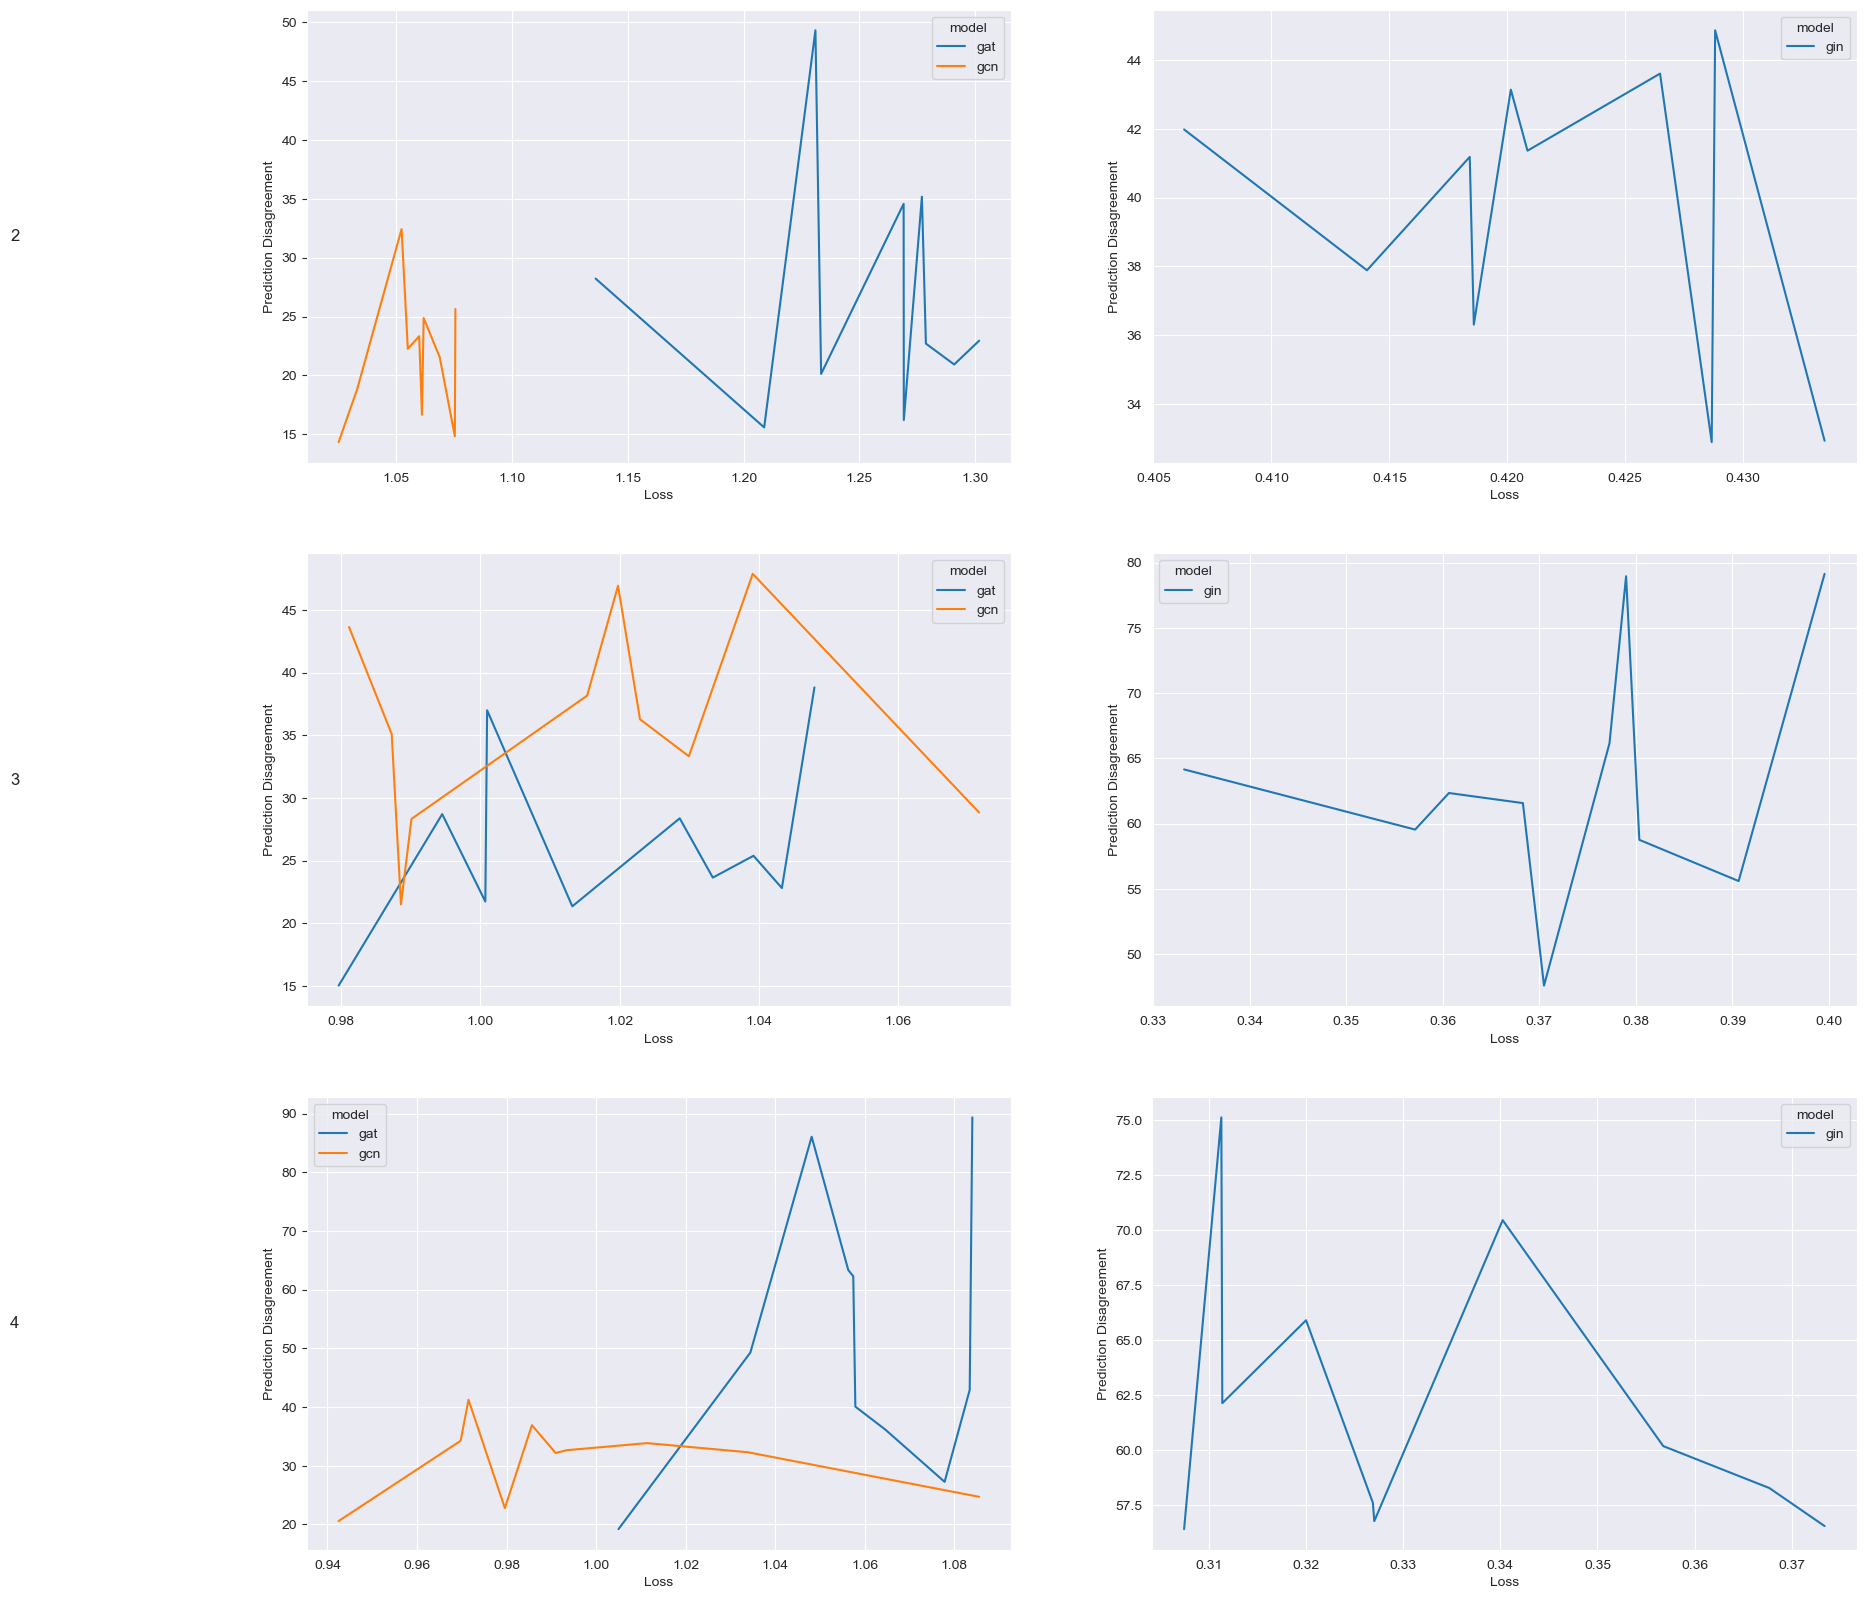

In [123]:
better_plot(e_df, index, err_style="band")

In [132]:
def better_plot2(data_frame, index='model.num_layers', err_style='band'):
    # fig, axes = plt.subplots(2, 2)
    columns = 2
    has_ras = False
    # if 'rsa_cos_0' in data_frame.columns:
    #     has_ras = True
    #     columns+=1
        
            
    rows = sorted(list(data_frame['model'].unique()))
    fig, axes = plt.subplots(len(rows), columns, figsize=(20, 20))
    for i, model in enumerate(rows):
        df = data_frame.loc[data_frame['model'] == model]
        # cols1 = [f'cca_{j}' for j in range(10) if f'cca_{j}' in df.columns]
        # df1 = df[['loss', index, *cols1]]
        # df1 = df1.melt(['loss', index], var_name='cols', value_name='CCA')
        # df1['cols'] = df1['cols'].apply(lambda x: int(x.split('_')[1]))

        cols2 = [f'cka_{j}' for j in range(10) if f'cka_{j}' in df.columns]
        df2 = df[['loss', index, *cols2]]
        df2 = df2.melt(['loss', index], var_name='cols', value_name='CKA')
        df2['cols'] = df2['cols'].apply(lambda x: int(x.split('_')[1]))
        
        # if has_ras:
        #     cols3 = [f'rsa_cos_{j}' for j in range(10) if f'rsa_cos_{j}' in df.columns]
        #     df3 = df[['loss', index, *cols3]]
        #     df3 = df3.melt(['loss', index], var_name='cols', value_name='RSA')
        #     df3['cols'] = df3['cols'].apply(lambda x: int(x.split('_')[2]))
        
        cols4 = [f'procrustess_{j}' for j in range(10) if f'procrustess_{j}' in df.columns]
        df4= df[['loss', index, *cols4]]
        df4 = df4.melt(['loss', index], var_name='cols', value_name='Procrustess_')
        df4['cols'] = df4['cols'].apply(lambda x: int(x.split('_')[1]))
        
        
        # models_0 = ['gat', 'gcn', 'gin']
        # models_1 = [x for x in df['model'].unique() if x not in models_0]
        
        
        # ax =  sns.boxplot(
        #     x='cols',
        #     y='CCA',
        #     data=df1,
        #     hue='model.num_layers',
        #     # err_style=err_style,
        #     ax=axes[i, 0],
        #     showfliers=False
        #     # sort=True,
        # )
        # 
        # ax.set(xlabel='Layer',
        #        ylabel='CCA',
        #        # title=''
        #        )
        
        ax =  sns.boxplot(
            x='cols',
            y='CKA',
            data=df2,
            hue='model.num_layers',
            # err_style=err_style,
            ax=axes[i, 0],
            showfliers=False
            # sort=True,
        )
        
        ax.set(xlabel='Layer',
               ylabel='CKA',
               # title=''
               )
         
        # if has_ras:
        #     ax =  sns.boxplot(
        #         x='cols',
        #         y='RSA',
        #         data=df3,
        #         hue='model.num_layers',
        #         # err_style=err_style,
        #         ax=axes[i, 1],
        #         showfliers=False
        #         # sort=True,
        #     )
        #     
        #     ax.set(xlabel='Layer',
        #            ylabel='RSA',
        #            # title=''
        #            )
         
        ax =  sns.boxplot(
            x='cols',
            y='Procrustess_',
            data=df4,
            hue='model.num_layers',
            # err_style=err_style,
            ax=axes[i, 1],
            showfliers=False
            # sort=True,
        )
        
        ax.set(xlabel='Layer',
               ylabel='Procrustess_',
               # title=''
               )
 
        
    for row, ax in zip(rows, axes[:, 0]):
        ax2 = ax.twinx()
        # move extra axis to the left, with offset
        ax2.yaxis.set_label_position('left')
        ax2.spines['left'].set_position(('axes', -0.2))
        # hide spine and ticks, set group label
        ax2.spines['left'].set_visible(False)
        ax2.set_yticks([])
        ax2.set_ylabel(row, rotation=90, size='large',
                       ha='right', va='center')
    
    plt.savefig('foo2.png')
    plt.show()

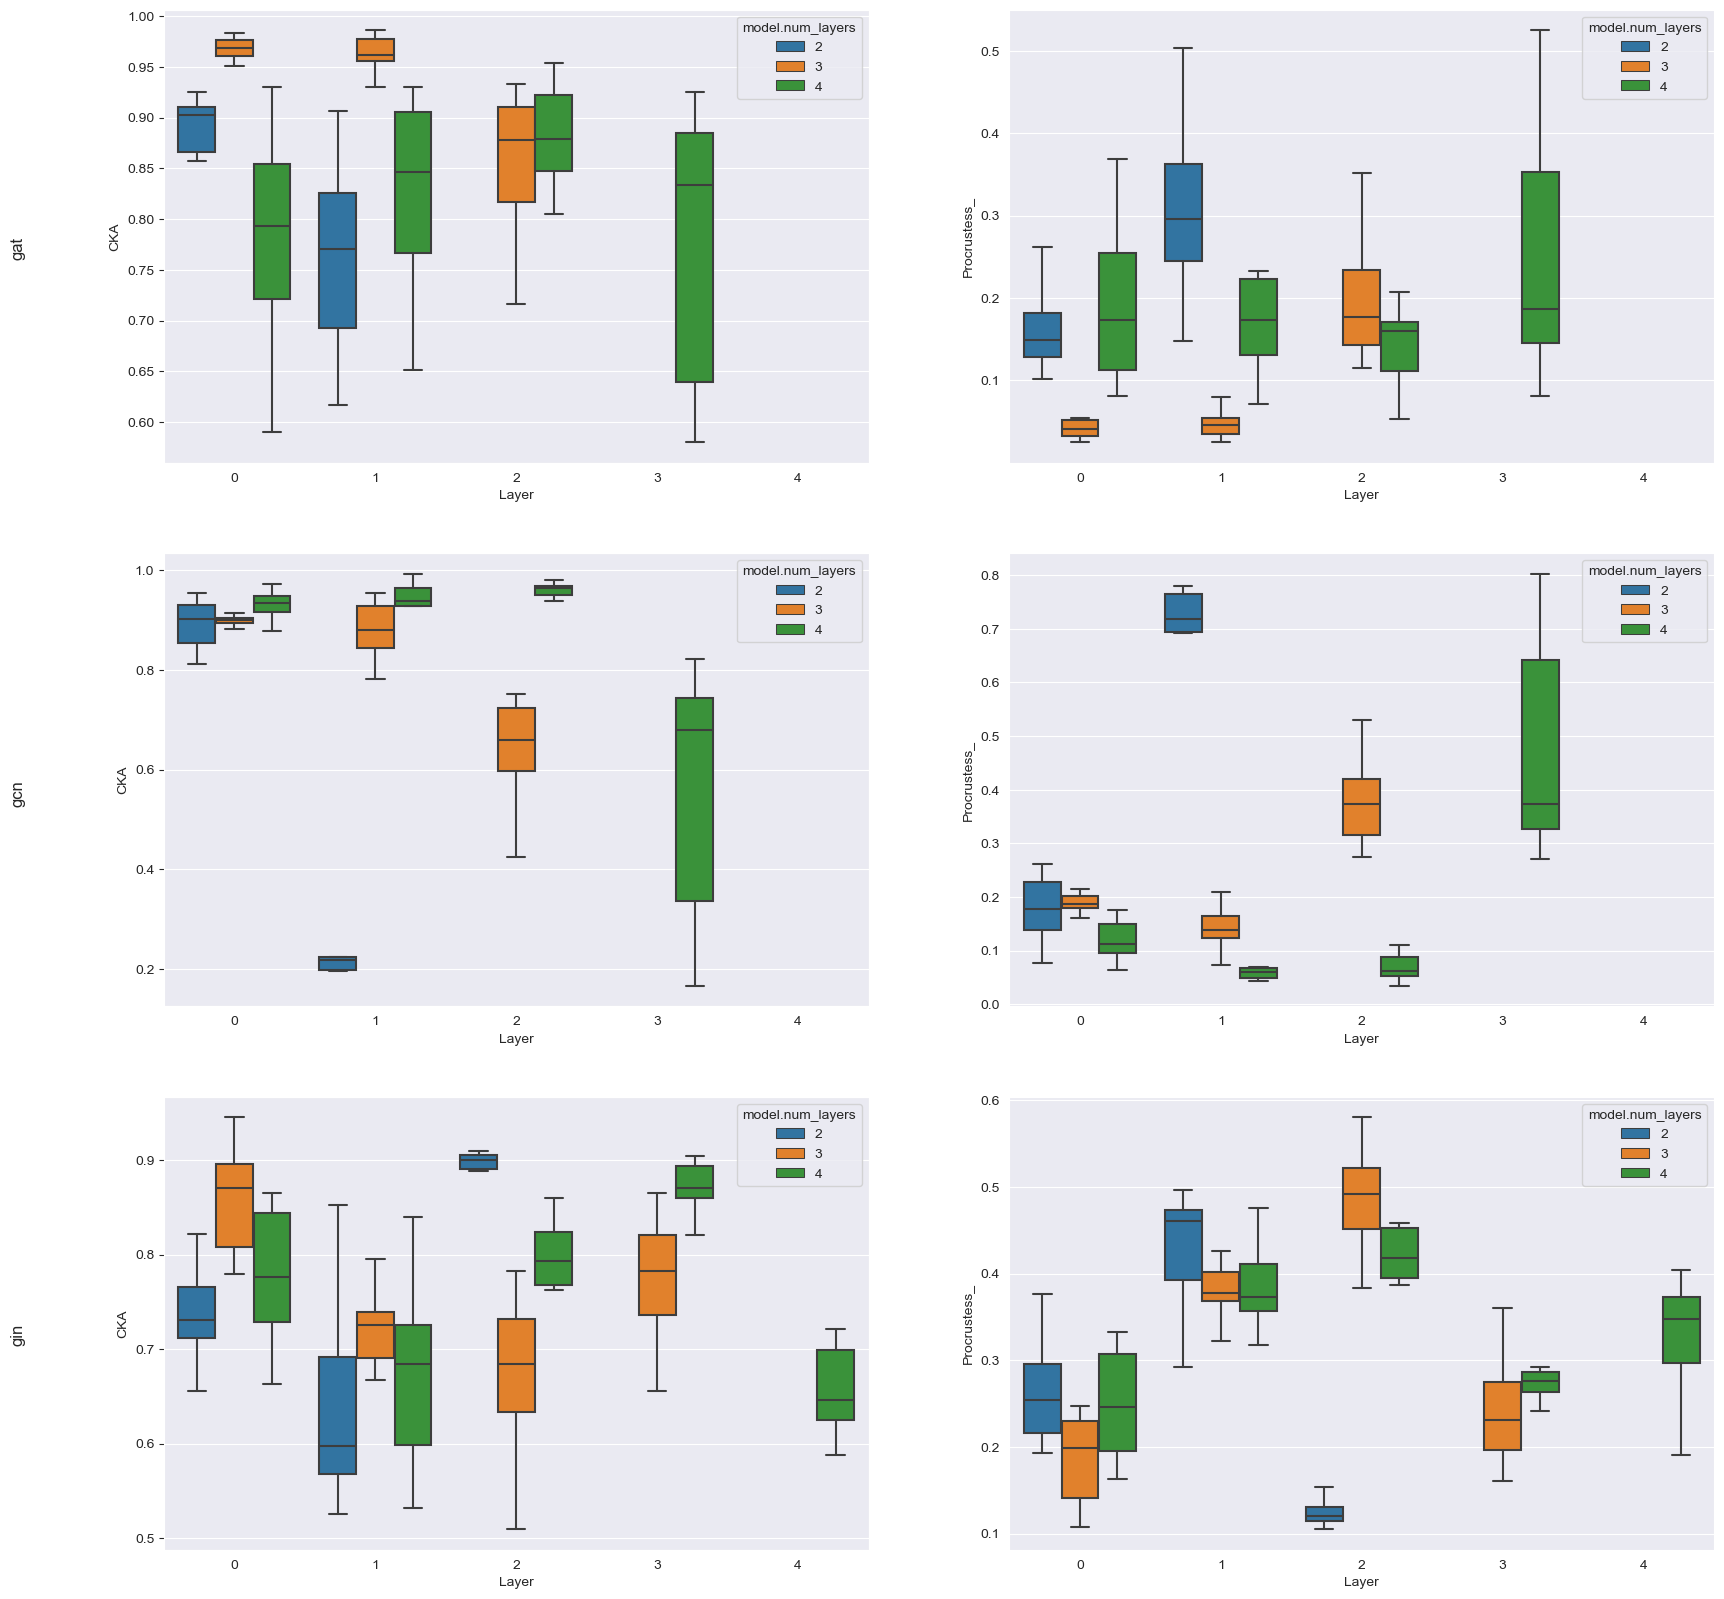

In [133]:
better_plot2(e_df, index, err_style="band")